# EHR DREAM Challenge - Patient Mortality Prediction EDA
- https://www.synapse.org/#!Synapse:syn20685954

In [1]:
import sys # to grab stderr
import json
# import jsonpickle
import numpy as np
import pandas as pd
# import sklearn as skl
# import xgboost as xgb
import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
# MANIFEST - list of versions on board 
import sys
import os
print(pd.datetime.now())
print('OS: '+os.uname().sysname)
print('Python: '+sys.version)
print('numpy: '+np.__version__)
print('pandas: '+pd.__version__)
# print('sklearn: '+skl.__version__)
# print('xgboost: '+xgb.__version__)
# print(pd.show_versions())

2020-02-21 15:40:57.013493
OS: Darwin
Python: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy: 1.16.2
pandas: 0.25.3


In [3]:
useful_df = pd.read_csv('OMOP_useful_columns.csv')
useful_df.shape

(120, 4)

In [4]:
useful_df

,TabNam,ColNam,primary,Useful
0,person,person_id,True,True
1,person,gender_concept_id,False,True
2,person,year_of_birth,False,True
3,person,month_of_birth,False,True
4,person,day_of_birth,False,True
...,...,...,...,...
115,observation,visit_occurrence_id,False,True
116,observation,observation_source_value,False,False
117,observation,observation_source_concept_id,False,False
118,observation,unit_source_value,False,False


## Underlying Cause of Death, 1999-2017

In [5]:
# from https://wonder.cdc.gov/ucd-icd10.html
# help: https://wonder.cdc.gov/wonder/help/ucd.html
#
cause = pd.read_csv('./Underlying Cause of Death, 1999-2017.tsv', sep='\t')

In [6]:
# print the notes
for line in cause.iloc[135:,0]:
    print(line)

---
Dataset: Underlying Cause of Death, 1999-2017
Query Parameters:
Group By: ICD-10 113 Cause List
Show Totals: Disabled
Show Zero Values: False
Show Suppressed: False
Calculate Rates Per: 100,000
Rate Options: Default intercensal populations for years 2001-2009 (except Infant Age Groups)
---
Help: See http://wonder.cdc.gov/wonder/help/ucd.html for more information.
---
Query Date: Feb 9, 2020 12:03:44 PM
---
Suggested Citation: Centers for Disease Control and Prevention, National Center for Health Statistics. Underlying Cause of Death
1999-2017 on CDC WONDER Online Database, released December, 2018. Data are from the Multiple Cause of Death Files, 1999-2017, as
compiled from data provided by the 57 vital statistics jurisdictions through the Vital Statistics Cooperative Program. Accessed
at http://wonder.cdc.gov/ucd-icd10.html on Feb 9, 2020 12:03:44 PM
---
Messages:
1. Totals and Percent of Total are disabled when data are grouped by 113 or 130 Cause Lists. Check Caveats below for mo

In [7]:
# drop the notes section
cause = cause[cause.columns[1:]][:134]

In [8]:
cause

,ICD-10 113 Cause List,ICD-10 113 Cause List Code,Deaths,Population,Crude Rate
0,#Salmonella infections (A01-A02),GR113-001,705.0,5.761466e+09,0.01
1,"#Shigellosis and amebiasis (A03,A06)",GR113-002,125.0,5.761466e+09,0.00
2,"Certain other intestinal infections (A04,A07-A09)",GR113-003,131576.0,5.761466e+09,2.28
3,#Tuberculosis (A16-A19),GR113-004,11769.0,5.761466e+09,0.20
4,Respiratory tuberculosis (A16),GR113-005,8939.0,5.761466e+09,0.16
...,...,...,...,...,...
129,"Events of undetermined intent (Y10-Y34,Y87.2,Y...",GR113-131,92161.0,5.761466e+09,1.60
130,"Discharge of firearms, undetermined intent (Y2...",GR113-132,4949.0,5.761466e+09,0.09
131,Other and unspecified events of undetermined i...,GR113-133,87212.0,5.761466e+09,1.51
132,"#Operations of war and their sequelae (Y36,Y89.1)",GR113-134,340.0,5.761466e+09,0.01


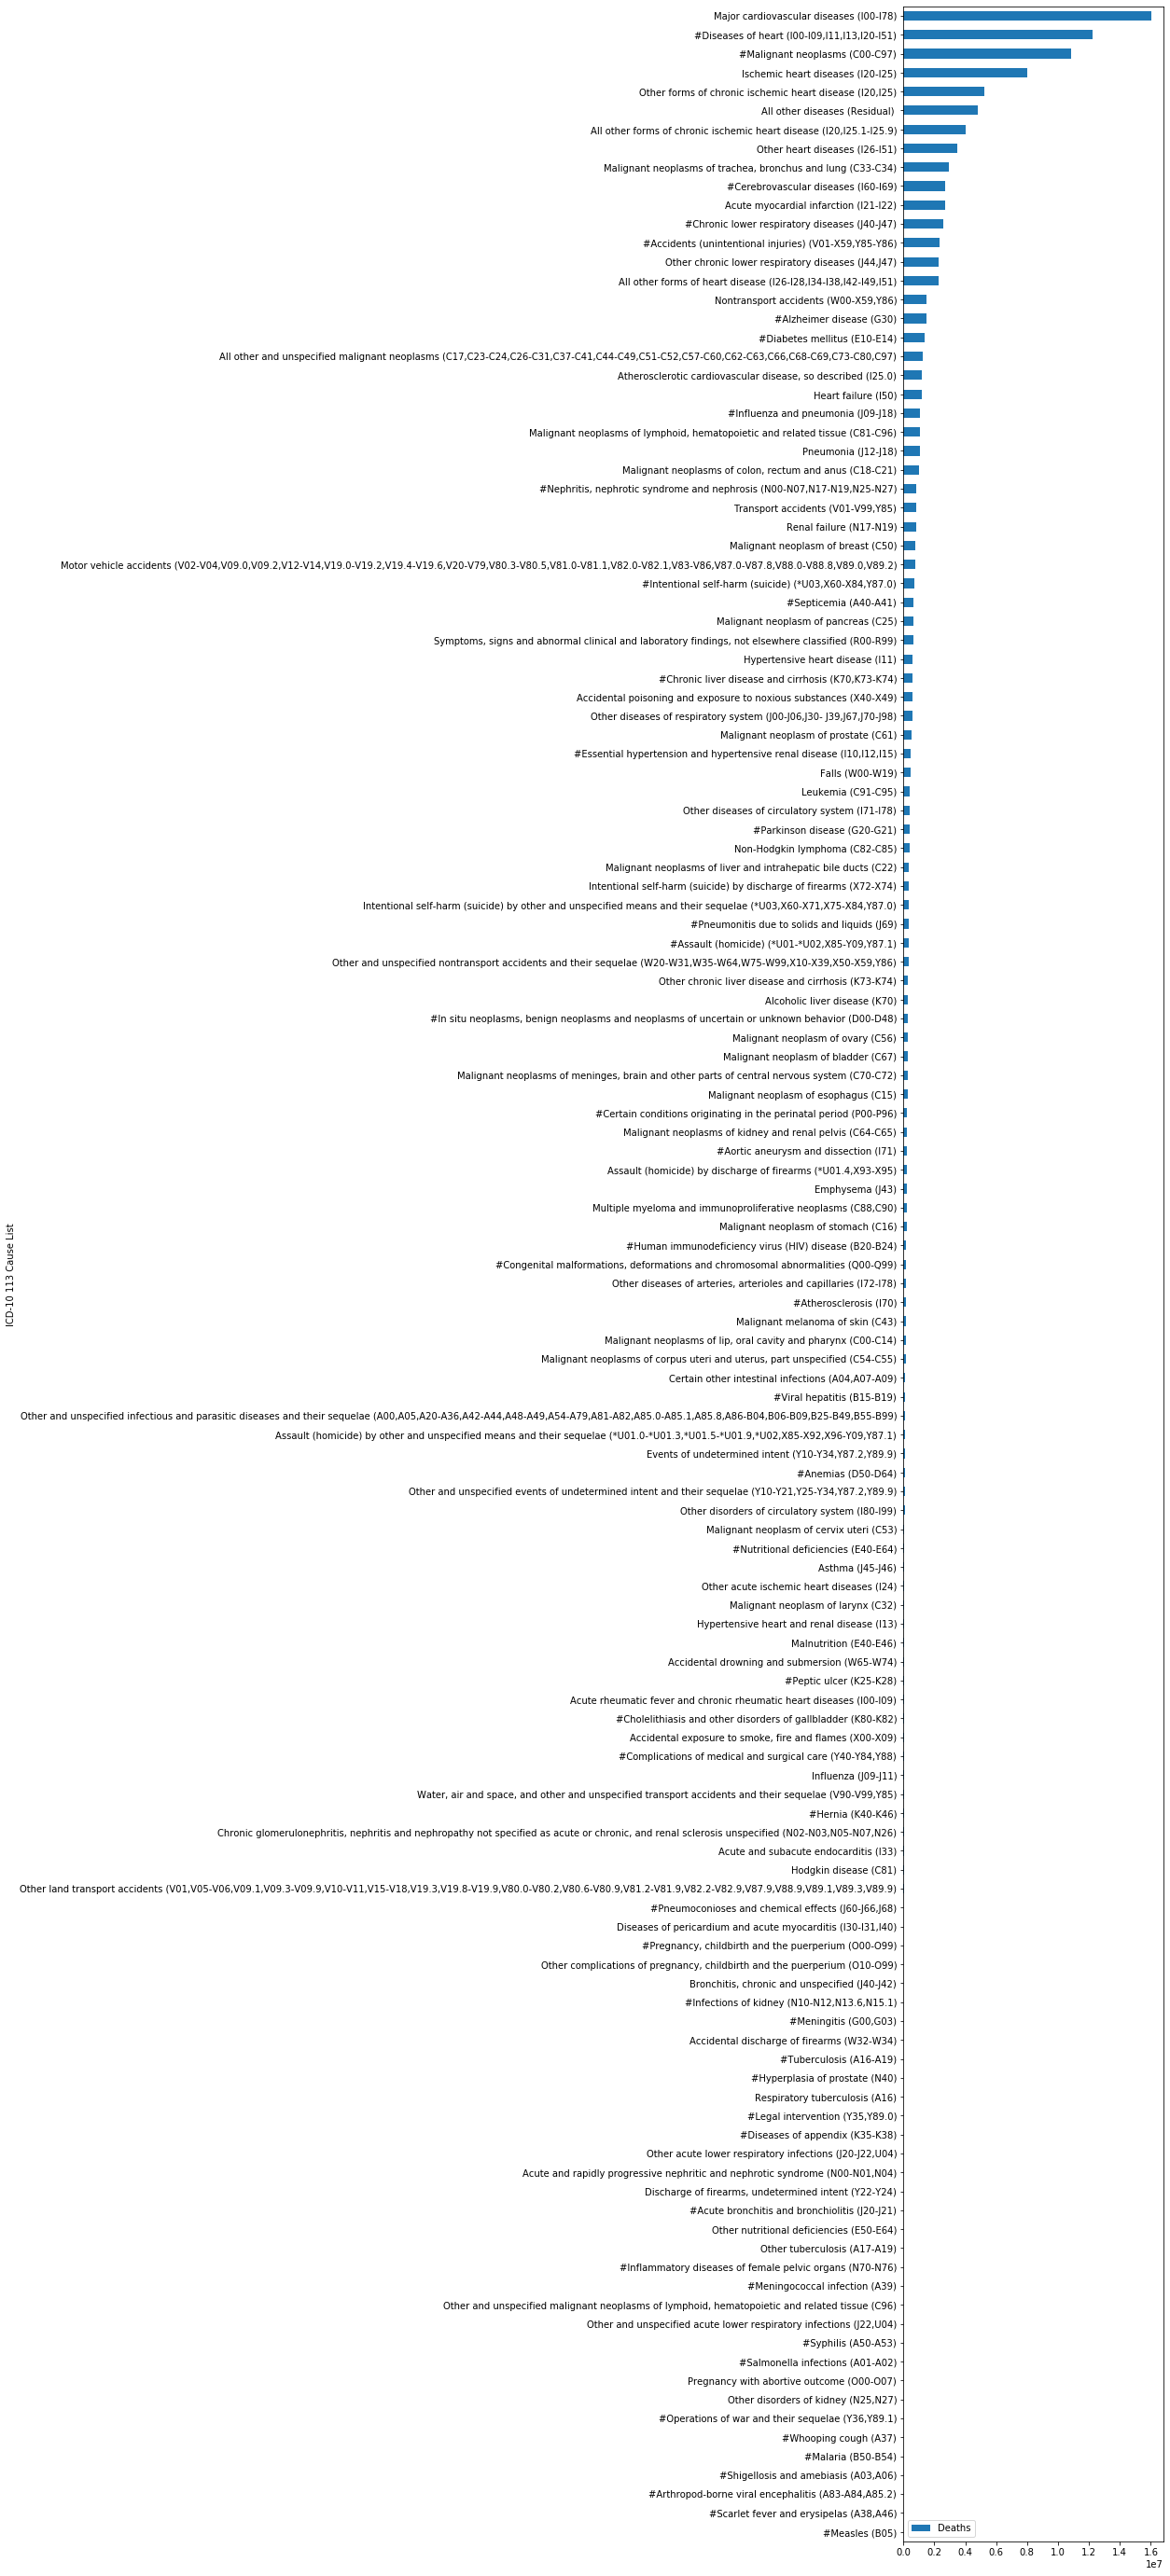

In [9]:
ax = cause.sort_values(by='Deaths', ascending=True).plot.barh(x='ICD-10 113 Cause List', y='Deaths', figsize=(5,50))

## Death EDA

In [10]:
FOLDER = './scratch/'
death180 = pd.read_csv(FOLDER+'train_death_all.csv.gz')
death180.shape

(3095, 5692)

In [11]:
death180=death180.fillna(0)
death180.old = death180.old.astype(int)
death180.total_quantity_of_drugs = death180.total_quantity_of_drugs.astype(int)

In [12]:
from sklearn import preprocessing
categoricals = ['ethnicity_concept_id',
               'gender_concept_id',
               'race_concept_id',
               'condition_status_concept_id',
               'race_concept_name']
for c in categoricals:
    le = preprocessing.LabelEncoder()
    death180[c]=le.fit_transform(death180[c])

In [13]:
death180.dtypes[:19]

old                                 int64
death_in_next_window                int64
visit_concept_name                  int64
ethnicity_concept_id                int64
gender_concept_id                   int64
race_concept_id                     int64
person_id                           int64
race_concept_name                   int64
number_of_visits                    int64
visit_duration                      int64
er_visit_count                      int64
inpatient_visit_count               int64
outpatient_visit_count              int64
window_id                           int64
condition_status_concept_id         int64
total_quantity_of_drugs             int64
condition_concept_id_list_0         int64
condition_concept_id_list_132393    int64
condition_concept_id_list_132412    int64
dtype: object

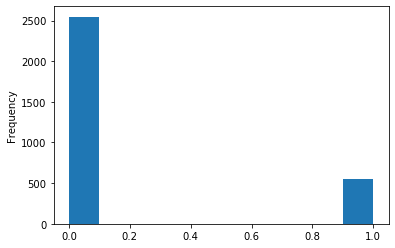

In [17]:
ax = death180.death_in_next_window.astype(int).plot.hist()

In [18]:
# NOTE: we have more than one record per patient 
len(death180.person_id.unique()), death180.shape[0]

(1096, 3095)

In [19]:
death180_describe_df = death180.describe(include='all').T.fillna('')
death180_describe_df[:30]

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
old,3095.0,,,,72.9073,12.0549,24,67,74,81,100
death_in_next_window,3095.0,2,False,2547,,,,,,,
visit_concept_name,3095.0,,,,0.621648,1.72606,0,0,0,1,41
ethnicity_concept_id,3095.0,,,,1.07916,0.9928,0,0,2,2,2
gender_concept_id,3095.0,2,True,1719,,,,,,,
race_concept_id,3095.0,,,,2.98675,2.01773,0,1,3,5,6
person_id,3095.0,,,,74514.7,42757.5,126,37568,72023,111210,151679
race_concept_name,3095.0,,,,2.758,1.71797,0,1,3,4,5
number_of_visits,3095.0,,,,4.0685,9.86646,1,1,2,4,207
visit_duration,3095.0,,,,0.684006,3.19223,0,0,0,0,78


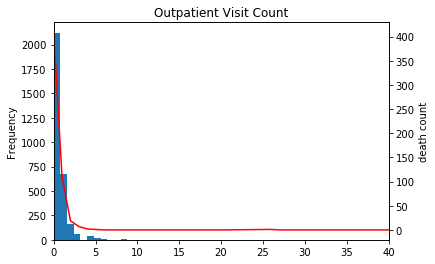

In [21]:
ax = death180.outpatient_visit_count.plot.hist(bins=50, title='Outpatient Visit Count')
ax2=ax.twinx()
ax=death180.groupby(death180.outpatient_visit_count).death_in_next_window.sum().plot(ax=ax2,color='r').set_ylabel('death count')

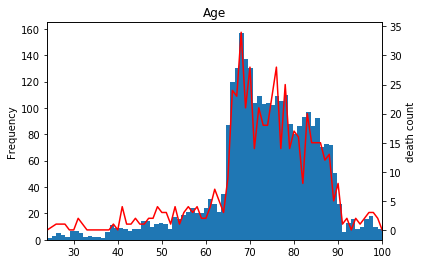

In [22]:
ax=death180.old.plot.hist(bins=75, title='Age',sharex=True)
ax2=ax.twinx()
ax=death180.groupby(death180.old).death_in_next_window.sum().plot(ax=ax2,color='r').set_ylabel('death count')

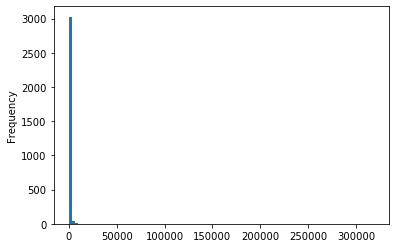

In [23]:
ax=death180.total_quantity_of_drugs.plot.hist(bins=100)

### DONE